이 코드는 Boostcamp AI Tech 미션-1 EDA를 참고하여 작성했습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.4 s, sys: 432 ms, total: 4.83 s
Wall time: 4.84 s


# Feature information

+ `userID` : 사용자의 고유 번호(7,442명)
+ `assessmentItemID` : 사용자가 푼 문항의 일련 번호   
+ `testId` : 사용자가 푼 문항이 포함된 시험지의 일련 번호   
+ `answerCode` : 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터   
+ `Timestamp` : 사용자가 문항을 푼 시간 정보
+ `KnowledgeTag` : 사용자가 푼 문항의 고유 태그

In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## baseline code feature engineering

In [4]:
df = df.sort_values(by=["userID", "Timestamp"], axis=0)

In [5]:
columns = ["userID", "assessmentItemID", "testId", "answerCode", "KnowledgeTag"]
group = (
    df[columns]
    .groupby("userID")
    .apply(
        lambda r: (
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)

In [6]:
len(group[0][0])

745

# Basic

In [7]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


### 문항 일련 번호 첫 번째 단어 A

In [8]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

첫 번째 단어는 A 밖에 없는 것을 확인할 수 있습니다.

### 문항 일련 번호 내 시험지 번호

In [9]:
sum(df['assessmentItemID'].apply(
    lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:])
)

2266586

문항 일련 번호의 1-6번째 자리와 시험지 번호의 1-3번째+마지막3자리 합이 같은지 확인합니다.   
전체 데이터 개수와 일치함을 알 수 있습니다.

### 시험지 번호 가운데 3자리 모두 000

In [10]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

# 기술 통계량 분석

In [11]:
def percentile(s):
    return np.sum(s)/len(s)

### groupby

(데이터프레임).groupby(분리할 Key).agg({합치고싶은특성: 어떻게 합칠지, ...})

### 사용자 분석

In [12]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    # 사용자 별로 몇 개 문제를 풀었는지 
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


### 사용자 문항 개수 도수분포표

Mean : 338.40


/tmp/ipykernel_82854/1102873745.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


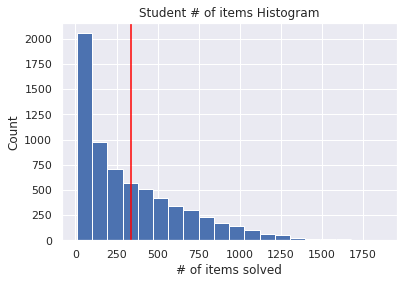

In [13]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

print(f"Mean : {stu_groupby['assessmentItemID'].mean():.2f}")

### 사용자 정답률 도수분포표

Mean : 62.89%


/tmp/ipykernel_82854/1835820120.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


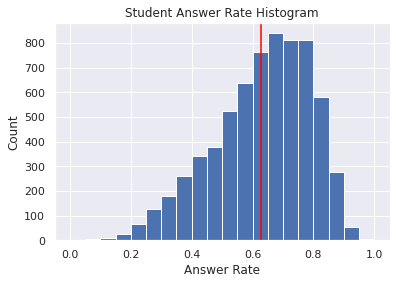

In [14]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

print(f"Mean : {stu_groupby['answerCode'].mean()*100:.2f}%")

### 문항 별 정답률 분석

In [15]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


Mean : 65.43%


/tmp/ipykernel_82854/116795926.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


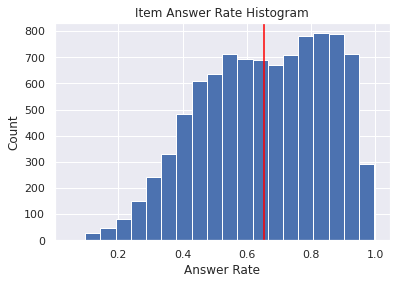

In [16]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

print(f"Mean : {prob_groupby['answerCode'].mean()*100:.2f}%")

### 시험지 별 정답률 분석

In [17]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


Mean : 66.80%


/tmp/ipykernel_82854/3960235913.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


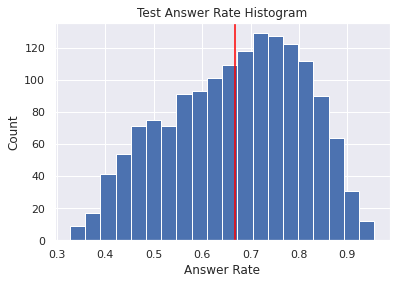

In [18]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

print(f"Mean : {test_groupby['answerCode'].mean()*100:.2f}%")

# 일반적인 EDA

### 문항을 더 많이 푼 학생이 문제를 더 잘 맞추는가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

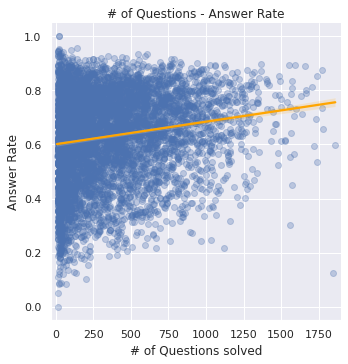

In [19]:
#분포도 위에 전반적인 동향을 살피고 싶을 때 `seaborn` 라이브러리의 `lmplot`을 사용하면 좋습니다.

g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [20]:
# 상관관계는 특성 간 인과를 알려주지 않지만 어느 정도 살펴보기는 해야하는 지표입니다.
print(f"정답률과 문제를 푼 개수 사이 인과관계: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

정답률과 문제를 푼 개수 사이 인과관계: 0.168


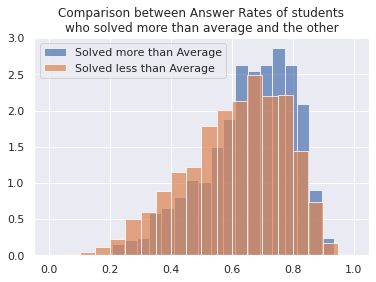

In [21]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [22]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


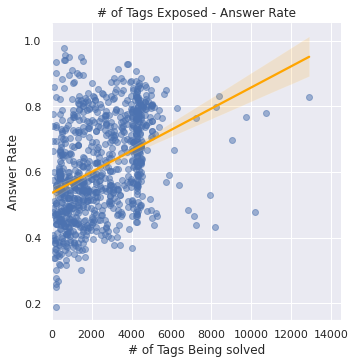

In [23]:
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate');

In [24]:
tag_groupby

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


In [25]:
print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계: {tag_groupby.corr()['answerCode']['userID']:.3f}")

태그를 풀었던 사용자의 수와 정답률 사이 상관관계: 0.376


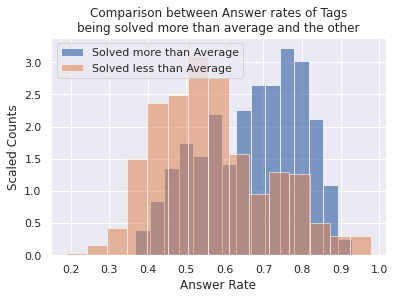

In [26]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

### 문항을 풀수록 실력이 늘어나는가?

In [27]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

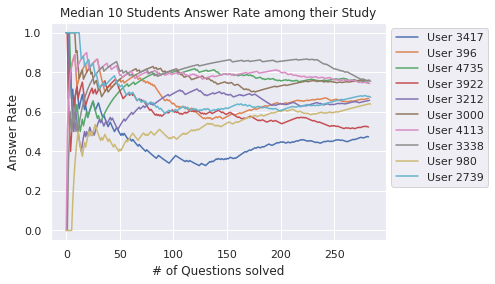

In [28]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

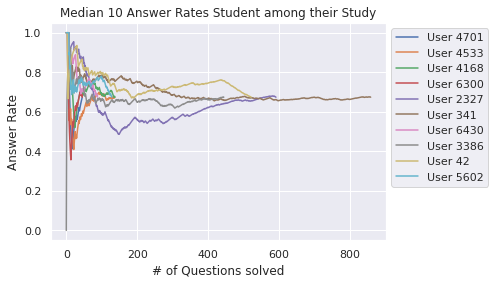

In [29]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [30]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

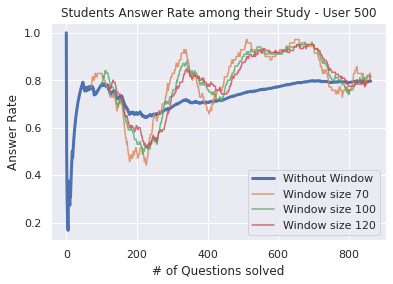

In [31]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

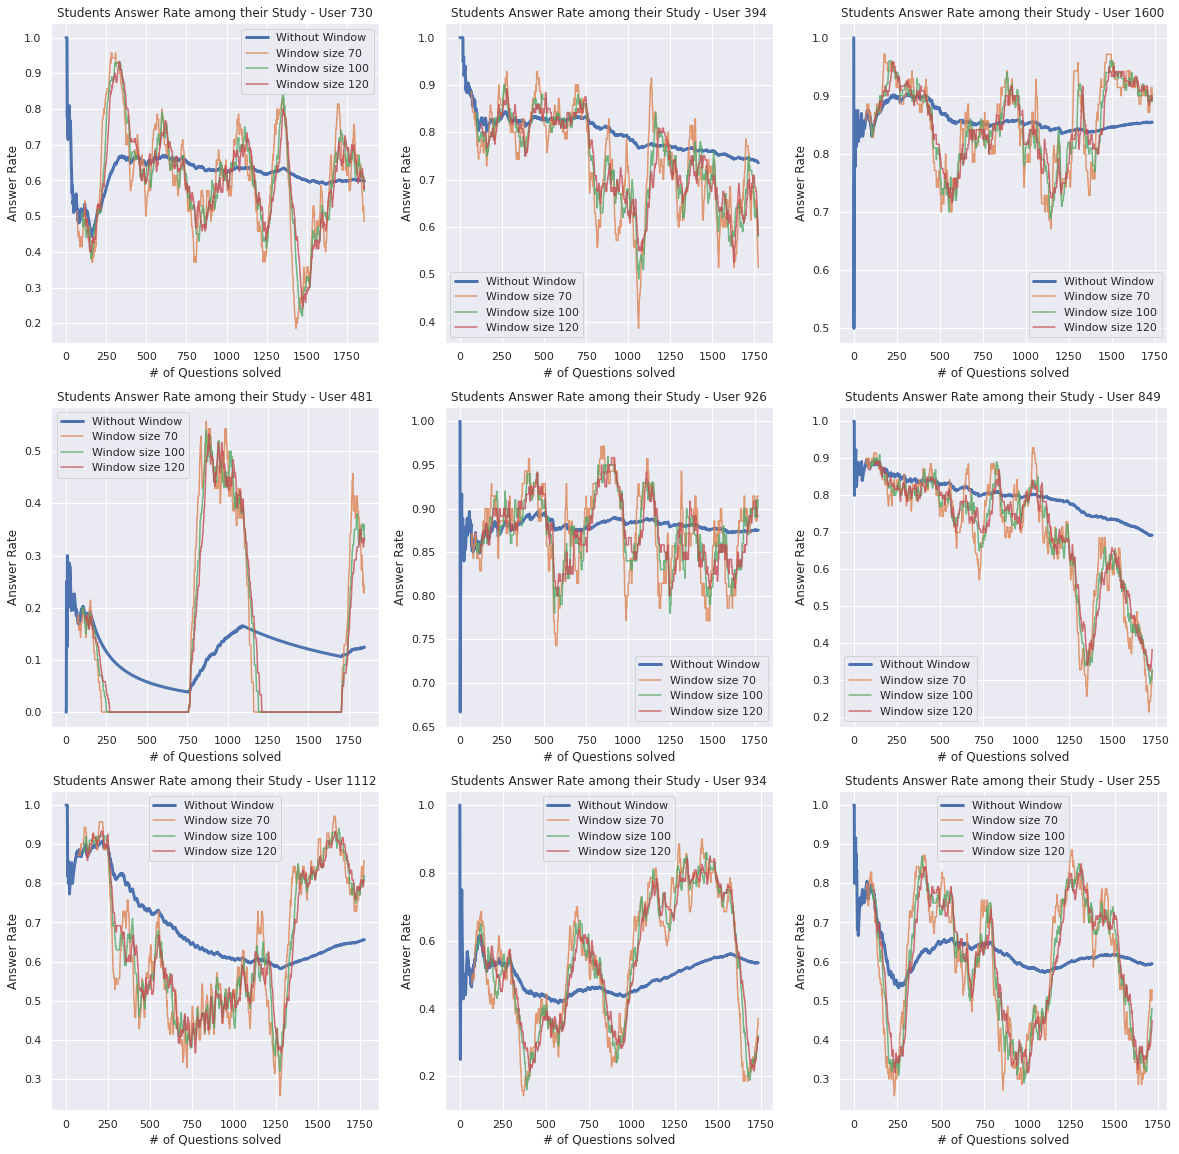

In [32]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [33]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [34]:
df['Timestamp']

0         2020-03-24 00:17:11
1         2020-03-24 00:17:14
2         2020-03-24 00:17:22
3         2020-03-24 00:17:29
4         2020-03-24 00:17:36
                  ...        
2266581   2020-06-05 06:50:21
2266582   2020-08-21 01:06:39
2266583   2020-08-21 01:06:50
2266584   2020-08-21 01:07:36
2266585   2020-08-21 01:08:49
Name: Timestamp, Length: 2266586, dtype: datetime64[ns]

In [33]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [35]:
diff

0                0.0
1                3.0
2                8.0
3                7.0
4                7.0
             ...    
2266581         24.0
2266582    6632178.0
2266583         11.0
2266584         46.0
2266585         73.0
Name: Timestamp, Length: 2266586, dtype: float64

In [38]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


In [36]:
elapsed_answer

,answerCode,userID
elapsed,,
0.0,0.578257,14101
1.0,0.246893,53829
2.0,0.227417,110005
3.0,0.229280,75785
4.0,0.248611,50022
...,...,...
24730516.0,1.000000,1
24870940.0,1.000000,1
24916659.0,1.000000,1


In [37]:
elapsed_hist

,answerCode,userID
elapsed,,
0.0,0.578257,14101
1.0,0.246893,53829
2.0,0.227417,110005
3.0,0.229280,75785
4.0,0.248611,50022
...,...,...
568.0,0.693069,101
570.0,0.705882,102
580.0,0.701613,124


(-10.0, 650.0)

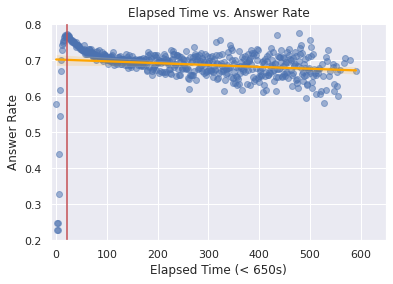

In [34]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

### 사용자가 푼 문항수 - 정답률(같은 문항수를 푼 사용자는 평균냄) 그래프

Text(0, 0.5, 'Answer Rate')

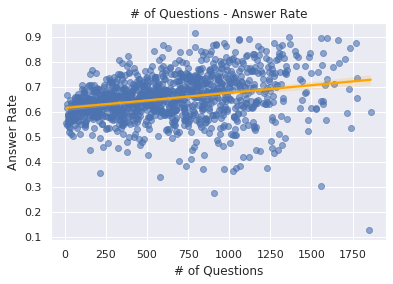

In [41]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
itemnum_ans['num_items'] = itemnum_ans.index

fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='num_items', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Questions - Answer Rate')
ax.set_xlabel('# of Questions')
ax.set_ylabel('Answer Rate')

### 사용자가 푼 문항수 - 정답률(비슷한 문항수를 푼 사용자(bins=300)는 평균냄) 그래프

In [42]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
)

In [43]:
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

Text(0, 0.5, 'Answer Rate')

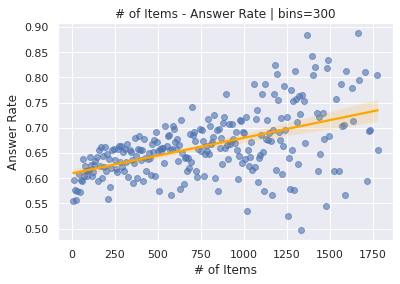

In [44]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')

### 더 많이 노출된 시험지는 정답률이 높을까? 

In [132]:
test_groupby = df.groupby('testId').agg({
    'testId': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,testId,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


In [147]:
test_groupby

,testId,answerCode
testId,,
A010000001,1585,0.926183
A010000002,1550,0.931613
A010000003,1615,0.846440
A010000004,1540,0.883117
A010000005,1595,0.855172
...,...,...
A090000070,344,0.418605
A090000071,360,0.336111
A090000072,270,0.418519


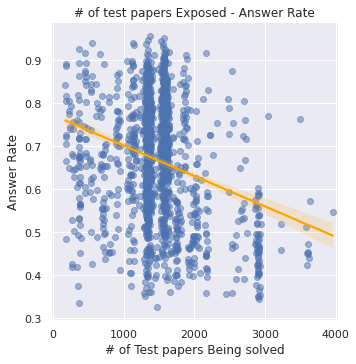

In [54]:
g = sns.lmplot(
    data=test_groupby,
    x='testId',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Test papers Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 4030))

ax = plt.gca()
ax.set_title('# of test papers Exposed - Answer Rate');

### 같은 시험지의 내용이나 같은 태그의 내용을 연달아 풀면, 정답률이 오를까?

In [118]:
max_user = df['userID'].value_counts().keys()[0]
max_user_data = df[df['userID']==max_user]
max_testId = max_user_data['testId'].value_counts().keys()[0]
max_tag = max_user_data['KnowledgeTag'].value_counts().keys()[0]

가장 많은 문제 수를 푼 유저를 통해 확인한 결과 같은 시험지, 같은 tag를 가진 문항을 여러번 푼다고 정답률이 상승하지 않음을 확인할 수 있었습니다.

In [120]:
max_user_data[max_user_data['testId']==max_testId]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,Time_hour
521619,730,A070052001,A070000052,1,2020-08-01 02:59:22,1261,3522.0,2
521620,730,A070052002,A070000052,1,2020-08-01 02:59:44,1261,22.0,2
521621,730,A070052003,A070000052,0,2020-08-01 03:01:02,9166,78.0,3
521622,730,A070052004,A070000052,1,2020-08-01 03:01:24,6796,22.0,3
521623,730,A070052005,A070000052,0,2020-08-01 03:01:41,6784,17.0,3
521624,730,A070052006,A070000052,1,2020-08-01 03:01:59,6796,18.0,3
521625,730,A070052007,A070000052,1,2020-08-01 03:06:29,6785,270.0,3
521626,730,A070052009,A070000052,1,2020-08-01 03:07:05,6785,36.0,3
521627,730,A070052008,A070000052,1,2020-08-01 03:07:06,1260,1.0,3
521628,730,A070052010,A070000052,1,2020-08-01 03:07:33,6785,27.0,3


In [121]:
max_user_data[max_user_data['KnowledgeTag']==max_tag]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,Time_hour
521284,730,A070032001,A070000032,1,2020-06-20 04:02:54,5788,85.0,4
521285,730,A070032002,A070000032,1,2020-06-20 04:03:00,5788,6.0,4
521286,730,A070032003,A070000032,1,2020-06-20 04:03:02,5788,2.0,4
521287,730,A070032004,A070000032,1,2020-06-20 04:03:04,5788,2.0,4
521288,730,A070032005,A070000032,1,2020-06-20 04:03:07,5788,3.0,4
521289,730,A070032006,A070000032,1,2020-06-20 04:03:15,5788,8.0,4
521290,730,A070032007,A070000032,1,2020-06-20 04:03:18,5788,3.0,4
521291,730,A070032008,A070000032,1,2020-06-20 04:03:19,5788,1.0,4
521292,730,A070032009,A070000032,1,2020-06-20 04:03:22,5788,3.0,4
521293,730,A070040001,A070000040,1,2020-06-20 04:29:41,5788,1579.0,4


### 정답을 특별히 잘 맞추는 시간대가 있을까?

In [68]:
print('가장 먼저 푼 시간대 :',df['Timestamp'].min())
print('가장 나중에 푼 시간대 :',df['Timestamp'].max()) 

가장 먼저 푼 시간대 : 2019-12-31 15:08:01
가장 나중에 푼 시간대 : 2020-12-29 16:46:21


In [70]:
df['Time_hour'] = df['Timestamp'].dt.hour

In [71]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,Time_hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,0
...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,6
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0,1
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,1
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,1


In [85]:
hour_groupby = df.groupby('Time_hour').agg({
    'Time_hour': 'count',
    'answerCode': percentile
})
hour_groupby.describe()

,Time_hour,answerCode
count,24.000000,24.000000
mean,94441.083333,0.636684
std,60726.479178,0.056093
min,10851.000000,0.528847
25%,28186.250000,0.615708
50%,110817.000000,0.643686
75%,148776.750000,0.675218
max,167792.000000,0.715727


In [92]:
hour_groupby['hour'] = np.arange(start=0, stop=24, step=1)

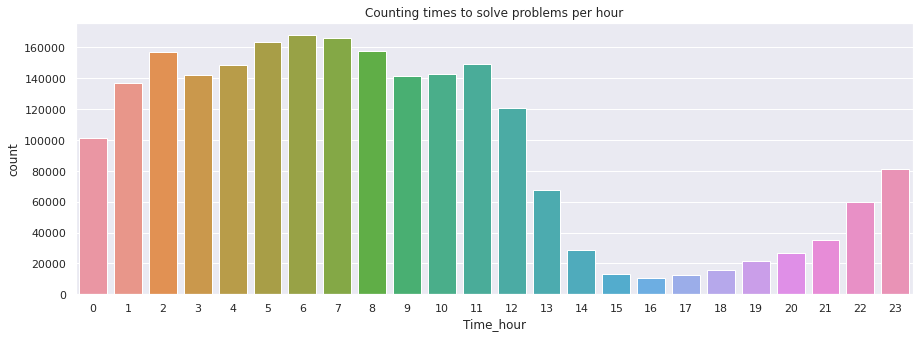

In [87]:
# 시각화 : 시간대 문제푸는 횟수 카운팅 그래프
plt.figure(figsize=(15,5))
ax = sns.countplot(x=df['Time_hour'])
ax.set_title('Counting times to solve problems per hour')
plt.show()

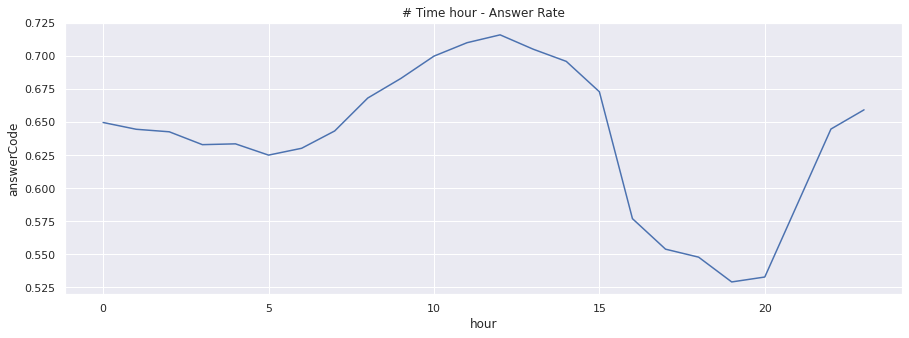

In [97]:
# 시간별 정답률 그래프
plt.figure(figsize=(15,5))
ax = sns.lineplot(x='hour', y='answerCode', ci=None, data=hour_groupby)
ax.set_title('# Time hour - Answer Rate')
plt.show()

문제를 가장 많이 푸는 시간대와 정답률은 비례하는 양상을 띄지 않았다.